# Ensemble Learning to Classify Patients with Heart Disease
<hr>
## Learning with ensembles

The goal behind ensemble methods is to combine different classifiers into a
meta-classifier that has a better generalization performance than each individual classifier alone. For example, assuming that we collected predictions from 10 experts, ensemble methods would allow us to strategically combine these predictions by the 10 experts to come up with a prediction that is more accurate and robust than the predictions by each individual expert. As we will see later in this chapter, there are several different approaches for creating an ensemble of classifiers. In this section, we will introduce a basic perception about how ensembles work and why they are typically recognized for yielding a good generalization performance.

In this chapter, we will focus on the most popular ensemble methods that use the majority voting principle. Majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50 percent of the votes. Strictly speaking, the term majority vote refers to binary class settings only. However, it is easy to generalize the majority voting principle to multi-class settings, which is called plurality voting. Here, we select the class label that received the most votes (mode). The following diagram illustrates the concept of majority and plurality voting for an ensemble of 10 classifiers where each unique symbol (triangle, square, and circle) represents a unique class label:

<img src = "images/ensemble.png" > 

Using the training set, we start by training m different classifiers (1,,mCC…). Depending on the technique, the ensemble can be built from different classification algorithms, for example, decision trees, support vector machines, logistic regression classifiers, and so on. Alternatively, we can also use the same base classification algorithm fitting different subsets of the training set. One prominent example of this approach would be the random forest algorithm, which combines different decision tree classifiers. The following diagram illustrates the concept of a general ensemble approach using majority voting:

<img src ="images/majorityvoting.png">

[[Images source]](https://github.com/rasbt/python-machine-learning-book/tree/master/images/image_gallery)

## Implementing a simple majority vote classifier 

After the short introduction to ensemble learning in the previous section, let's start with a warm-up exercise and implement a simple ensemble classifier for majority voting in Python.

The algorithm that we are going to implement will allow us to combine different classification algorithms associated with individual weights for confidence. Our goal is to build a stronger meta-classifier that balances out the individual classifiers' weaknesses on a particular dataset.

Let's assume that we have an ensemble of three base classifiers c1,c2,c3 and want to predict the class label of a given sample instance x. Two out of three base classifiers predict the class label 0, and one c3 predicts that the sample belongs to class 1.
If we weight the predictions of each base classifier equally, the majority vote will predict that the sample belongs to class 0.

Now let's assign a weight of 0.6 to c3 and weight c1 and c2 by a coefficient of 0.2, respectively.

More intuitively, since 3 x 0.2 = 0.6, we can say that the prediction made by c3 has three times more weight than the predictions by c1 or c2 (), respectively.To translate the concept of the weighted majority vote into Python code, we can use NumPy's convenient argmax and bincount functions:

In [1]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

Certain classifiers in scikit-learn can also return the probability of a predicted class label via the predict_proba method. Using the predicted class probabilities instead of the class labels for majority voting can be useful if the classifiers in our ensemble are well calibrated.

Let's assume that our classifiers c1,c2,c3 returns the following class membership probabilities for a particular sample x:
c1(x) -> [0.9,0.1] 
c2(x) -> [0.8,0.2] 
c3(x) -> [0.4,0.6] 

To implement the weighted majority vote based on class probabilities, we can again make use of NumPy using numpy.average and np.argmax:

In [2]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [3]:
np.argmax(p)

0

Putting everything together, let's now implement a MajorityVoteClassifier
in Python:

In [4]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

A lot of comments are added to the code to better understand the individual parts. However, before we implement the remaining methods, let's take a quick break and discuss some of the code that may look confusing at first. We used the parent classes BaseEstimator and ClassifierMixin to get some base functionality for free, including the methods get_params and set_params to set and return the classifier's parameters as well as the score method to calculate the prediction accuracy, respectively. Also note that we imported six to make the MajorityVoteClassifier compatible with Python 2.7.

Next we will add the predict method to predict the class label via majority vote based on the class labels if we initialize a new MajorityVoteClassifier object with vote='classlabel'. Alternatively, we will be able to initialize the ensemble classifier with vote='probability' to predict the class label based on the class membership probabilities. Furthermore, we will also add a predict_proba method to return the average probabilities, which is useful to compute the Receiver Operator Characteristic area under the curve (ROC AUC).

Also, note that we defined our own modified version of the 'get_params' methods to use the '_name_estimators' function in order to access the parameters of individual classifiers in the ensemble. This may look a little bit complicated at first, but it will make perfect sense when we use grid search for hyperparameter-tuning in
later sections.

## Combining different algorithms for classification with majority vote

Now it is about time to put the MajorityVoteClassifier that we implemented in the previous section into action. But first, let's prepare a dataset that we can test it on.

## Heart Disease Data Set 

We would using the Heart Disease Data Set. The dataset actually contains 76 attributes but for simplicity we would be dealing with only the most important 14 attributes. Using this 14 attributes, our job would be to predict if the patient has a heart disease or not.

#### Attribute Information:

The 14 attributes used: 
[age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal num]

Complete attribute documentation: 
1. age: age in years 
2. sex: sex (1 = male; 0 = female) 
3. cp: chest pain type 
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
5. chol: serum cholestoral in mg/dl 
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
7. restecg: resting electrocardiographic results 
    - Value 0: normal 
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. thalach: maximum heart rate achieved 
9. exang: exercise induced angina (1 = yes; 0 = no) 
10. oldpeak = ST depression induced by exercise relative to rest 
11. slope: the slope of the peak exercise ST segment 
    - Value 1: upsloping 
    - Value 2: flat 
    - Value 3: downsloping 
12. ca: number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
14. num: diagnosis of heart disease (angiographic disease status) 

We would be using the preprocessed dataset. It can be downloaded from here : http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

Once downloaded, we can move on to code:

In [5]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
cols = ['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'num']

In [7]:
import pandas as pd
# read .csv from provided dataset
csv_filename="processed.cleveland.data"

# Seperator = ' ' i.e a single space
df=pd.read_csv(csv_filename,sep=',',names=cols)

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Thus we have our dataset. But we want our task to be a binary classification task i.e we would like to classify whether the patient has a heart disease or not. However our target variable 'num' contains 5 values 0,1,2,3,4. We would simply attempt to distinguish presence (values 1,2,3,4) from absence (value 0). We can make clean our target variable values accordingly:

In [9]:
count0 = 0
for z in df['num']:
    if z == 0:
        count0 = count0 + 1
print (count0)

164


In [10]:
for v in df['num']:
    if v != 0 :
        df['num'].replace(v,1,inplace=True)

In [11]:
count0 = 0
for z in df['num']:
    if z == 0:
        count0 = count0 + 1
print (count0)

164


In [12]:
count0 = 0
for z in df['num']:
    if z != 0:
        count0 = count0 + 1
print (count0)

139


In [13]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Our data contains 6 row with missing values. These values are represented by "?". So first we replace these "?" with NaN and then drop all rows which contain NaNs. We can simply achive this by doing the following: 

In [14]:
df.replace("?",np.NaN,inplace=True)

In [15]:
df.dropna(axis=0, inplace=True, how='any')

In [16]:
df = df.reset_index(drop=True)

In [17]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Now we can move on to classification of our data. 

In [18]:
features = df.columns[:-1]

In [19]:
features

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [20]:
X = df[features]
y = df['num']

In [21]:
y.unique()

array([0, 1], dtype=int64)

Our target variable y has 2 unique values 0  and 1. 0 means the patient doesn't have a heart disease; 1 means unfortunately he/she does. 

We split our dataset into 70% training set and 30% testing set.

In [22]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.3, 
                        random_state=1)

In [23]:
 X_train.shape, y_train.shape

((207, 13), (207,))

### Feature importances with forests of trees
This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [25]:
for f in range(5):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))

1. feature 12 - thal (0.167814)
2. feature 11 - ca (0.124068)
3. feature 2 - cp (0.110151)
4. feature 7 - thalach (0.083754)
5. feature 8 - exang (0.082387)


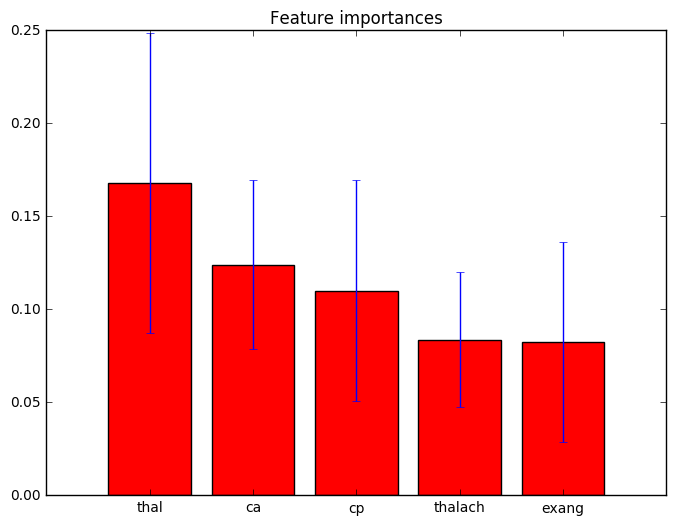

In [26]:
best_features = []
for i in indices[:5]:
    best_features.append(features[i])

# Plot the top 5 feature importances of the forest
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(5), importances[indices][:5], 
       color="r",  yerr=std[indices][:5], align="center")
plt.xticks(range(5), best_features)
plt.xlim([-1, 5])
plt.show()

### Decision Tree accuracy and time elapsed caculation

In [27]:
from time import time
t0=time()
print ("DecisionTree")

dt = DecisionTreeClassifier(min_samples_split=20,random_state=99)
# dt = DecisionTreeClassifier(min_samples_split=20,max_depth=5,random_state=99)

clf_dt=dt.fit(X_train,y_train)

print ("Acurracy: ", clf_dt.score(X_test,y_test))
t1=time()
print ("time elapsed: ", t1-t0)

DecisionTree
Acurracy:  0.722222222222
time elapsed:  0.009000539779663086


In [28]:
tt0=time()
print ("cross result========")
scores = cross_validation.cross_val_score(dt, X, y, cv=5)
print (scores)
print (scores.mean())
tt1=time()
print ("time elapsed: ", tt1-tt0)

cross result========
[ 0.71666667  0.86666667  0.79661017  0.76271186  0.74576271]
0.777683615819
time elapsed:  0.04300236701965332


#### Tuning our hyperparameters using GridSearch

In [29]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(criterion='entropy'))
])

parameters = {
    'clf__max_depth': (15, 20 , 25),
    'clf__min_samples_leaf': (3, 5, 10)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

print ('Best score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)

print (classification_report(y_test, predictions))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best score: 0.743
Best parameters set:
	clf__max_depth: 25
	clf__min_samples_leaf: 3
             precision    recall  f1-score   support

          0       0.80      0.69      0.74        51
          1       0.65      0.77      0.71        39

avg / total       0.73      0.72      0.72        90



[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    7.3s finished


### Naive Bayes accuracy and time elapsed caculation

In [30]:
t4=time()
print ("NaiveBayes")
nb = BernoulliNB()
clf_nb=nb.fit(X_train,y_train)
print ("Acurracy: ", clf_nb.score(X_test,y_test))
t5=time()
print ("time elapsed: ", t5-t4)

NaiveBayes
Acurracy:  0.788888888889
time elapsed:  0.024001598358154297


In [31]:
tt4=time()
print ("cross result========")
scores = cross_validation.cross_val_score(nb, X, y, cv=5)
print (scores)
print (scores.mean())
tt5=time()
print ("time elapsed: ", tt5-tt4)

cross result========
[ 0.78333333  0.8         0.77966102  0.77966102  0.81355932]
0.791242937853
time elapsed:  0.0500028133392334


### KNN accuracy and time elapsed caculation

In [32]:
t6=time()
print ("KNN")
knn = KNeighborsClassifier()
clf_knn=knn.fit(X_train, y_train)
print ("Acurracy: ", clf_knn.score(X_test,y_test) )
t7=time()
print ("time elapsed: ", t7-t6)

KNN
Acurracy:  0.677777777778
time elapsed:  0.0060002803802490234


In [33]:
tt6=time()
print ("cross result========")
scores = cross_validation.cross_val_score(knn, X, y, cv=5)
print (scores)
print (scores.mean())
tt7=time()
print ("time elapsed: ", tt7-tt6)

cross result========
[ 0.61666667  0.7         0.61016949  0.74576271  0.69491525]
0.673502824859
time elapsed:  0.06500363349914551


### SVM accuracy and time elapsed caculation¶

In [34]:
t7=time()
print ("SVM")

svc = SVC()
clf_svc=svc.fit(X_train, y_train)
print ("Acurracy: ", clf_svc.score(X_test,y_test) )
t8=time()
print ("time elapsed: ", t8-t7)

SVM
Acurracy:  0.566666666667
time elapsed:  0.017000913619995117


In [35]:
tt7=time()
print ("cross result========")
scores = cross_validation.cross_val_score(svc, X,y, cv=5)
print (scores)
print (scores.mean())
tt8=time()
print ("time elapsed: ", tt7-tt6)

cross result========
[ 0.53333333  0.53333333  0.54237288  0.54237288  0.54237288]
0.538757062147
time elapsed:  0.27701568603515625


Using the training dataset, we now will train two different classifiers— a decision tree classifier, and a k-nearest neighbors classifier—and look at their individual performances via a 10-fold cross-validation
on the training dataset before we combine them into an ensemble classifier:

In [36]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

clf2 = DecisionTreeClassifier(max_depth=1, 
                              criterion='entropy', 
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1, 
                            p=2, 
                            metric='minkowski')

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.69 (+/- 0.08) [Decision Tree]
ROC AUC: 0.75 (+/- 0.09) [KNN]


As you can see the accuracies o our individual classifiers are almost same and are on the high side. Now let's move on to the more exciting part and combine the individual classifiers for majority rule voting in our MajorityVoteClassifier:

In [37]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(
                classifiers=[clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

ROC AUC: 0.69 (+/- 0.08) [Decision Tree]
ROC AUC: 0.75 (+/- 0.09) [KNN]
ROC AUC: 0.80 (+/- 0.09) [Majority Voting]


As we can see, the performance of the MajorityVotingClassifier has substantially improved over the individual classifiers in the 10-fold cross-validation evaluation.

## Evaluating and tuning the ensemble classifier

In this section, we are going to compute the ROC curves from the test set to check if the MajorityVoteClassifier generalizes well to unseen data. We should remember that the test set is not to be used for model selection; its only purpose is to report an unbiased estimate of the generalization performance of a classifier system. The code is as follows:

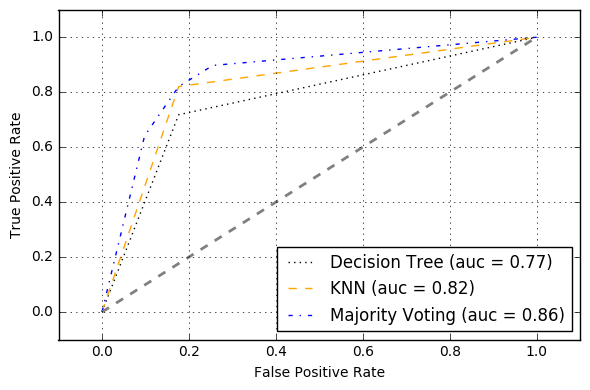

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, 
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, 
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

As we can see in the resulting ROC, the ensemble classifier also performs well on
the test set (ROC AUC = 0.86).

Before we tune the individual classifier parameters for ensemble classification, let's call the get_params method to get a basic idea of how we can access the individual parameters inside a GridSearch object:

In [39]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_st

Based on the values returned by the get_params method, we now know how to access the individual classifier's attributes. Let's now tune the decision tree depth via a grid search for demonstration purposes. The code is as follows:

In [40]:
from sklearn.grid_search import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1,2],
          'pipeline__clf__n_neighbors': [5,15,20]}

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, scores.std() / 2, params))

0.850+/-0.04 {'pipeline__clf__n_neighbors': 5, 'decisiontreeclassifier__max_depth': 1}
0.861+/-0.03 {'pipeline__clf__n_neighbors': 15, 'decisiontreeclassifier__max_depth': 1}
0.870+/-0.03 {'pipeline__clf__n_neighbors': 20, 'decisiontreeclassifier__max_depth': 1}
0.856+/-0.04 {'pipeline__clf__n_neighbors': 5, 'decisiontreeclassifier__max_depth': 2}
0.868+/-0.04 {'pipeline__clf__n_neighbors': 15, 'decisiontreeclassifier__max_depth': 2}
0.875+/-0.04 {'pipeline__clf__n_neighbors': 20, 'decisiontreeclassifier__max_depth': 2}


After the grid search has completed, we can print the different hyperparameter
value combinations and the average ROC AUC scores computed via 10-fold
cross-validation. The code is as follows:

In [41]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'pipeline__clf__n_neighbors': 20, 'decisiontreeclassifier__max_depth': 2}
Accuracy: 0.87


As we can see, we get the best cross-validation results when we choose a higher n_neighbors (n = 20) whereas the tree depth does not seem to affect the performance at all, suggesting that a decision stump is sufficient to separate the data. To remind ourselves that it is a bad practice to use the test dataset more than once for model evaluation, we are not going to estimate the generalization performance of the tuned hyperparameters in this section. We will move on swiftly to an alternative approach for ensemble learning: bagging.

## Bagging -- Building an ensemble of classifiers from bootstrap samples

Bagging is an ensemble learning technique that is closely related to the MajorityVoteClassifier that we implemented in the previous section,
as illustrated in the following diagram:

<img src = "images/bagging.png">

However, instead of using the same training set to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training set, which is why bagging is also known as bootstrap aggregating.

In [42]:
X = df[features]
y = df['num']

In [43]:
X.shape , y.shape

((297, 13), (297,))

Next we encode the class labels into binary format and split the dataset into
60 percent training and 40 percent test set, respectively:

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

A BaggingClassifier algorithm is already implemented in scikit-learn, which we can import from the ensemble submodule. Here, we will use an unpruned decision tree as the base classifier and create an ensemble of 500 decision trees fitted on different bootstrap samples of the training dataset:

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

Next we will calculate the accuracy score of the prediction on the training and test dataset to compare the performance of the bagging classifier to the performance of a single unpruned decision tree. Based on the accuracy values, the unpruned decision tree predicts all class labels of the training samples correctly; however, the substantially lower test accuracy indicates high variance (overfitting) of the model:

In [46]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.714
Bagging train/test accuracies 1.000/0.756


Although the training accuracies of the decision tree and bagging classifier are similar on the training set (both 1.0), we can see that the bagging classifier has a slightly better generalization performance as estimated on the test set.

In practice, more complex classification tasks and datasets' high dimensionality can easily lead to overfitting in single decision trees and this is where the bagging algorithm can really play out its strengths. Finally, we shall note that the bagging algorithm can be an effective approach to reduce the variance of a model. However, bagging is ineffective in reducing model bias, which is why we want to choose an ensemble of classifiers with low bias, for example, unpruned decision trees.

## Leveraging weak learners via adaptive boosting 

In this section about ensemble methods, we will discuss boosting with a special focus on its most common implementation, AdaBoost (short for Adaptive Boosting).

In boosting, the ensemble consists of very simple base classifiers, also often referred to as weak learners, that have only a slight performance advantage over random guessing. A typical example of a weak learner would be a decision tree stump. The key concept behind boosting is to focus on training samples that are hard to classify, that is, to let the weak learners subsequently learn from misclassified training samples to improve the performance of the ensemble. In contrast to bagging, the initial formulation of boosting, the algorithm uses random subsets of training samples drawn from the training dataset without replacement. The original boosting procedure is summarized in four key steps as follows:

1. Draw a random subset of training samples d1 without replacement from the training set D to train a weak learner C1.
2. Draw second random training subset d2 without replacement from the training set and add 50 percent of the samples that were previously misclassified to train a weak learner C2.
3. Find the training samples d3 in the training set D on which C1 and C2 disagree to train a third weak learner C3.
4. Combine the weak learners C1, C2, and C3 via majority voting.

Boosting can lead to a decrease in bias as well as variance compared to bagging models. In practice, however, boosting algorithms such as AdaBoost are also known for their high variance, that is, the tendency to overfit the training data. In contrast to the original boosting procedure as described here, AdaBoost uses the complete training set to train the weak learners where the training samples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble. Take a look at the following figure to get a better grasp of the basic concept behind AdaBoost:

<img src = "images/adaboost.png">

To walk through the AdaBoost illustration step by step, we start with subfigure 1, which represents a training set for binary classification where all training samples are assigned equal weights. Based on this training set, we train a decision stump (shown as a dashed line) that tries to classify the samples of the two classes (triangles and circles) as well as possible by minimizing the cost function (or the impurity score in the special case of decision tree ensembles). For the next round (subfigure 2),
we assign a larger weight to the two previously misclassified samples (circles). Furthermore, we lower the weight of the correctly classified samples. The next decision stump will now be more focused on the training samples that have the largest weights, that is, the training samples that are supposedly hard to classify. The weak learner shown in subfigure 2 misclassifies three different samples from the circle-class, which are then assigned a larger weight as shown in subfigure 3. Assuming that our AdaBoost ensemble only consists of three rounds of boosting, we would then combine the three weak learners trained on different reweighted training subsets by a weighted majority vote, as shown in subfigure 4.

Skipping to the more practical part, let's now train an AdaBoost ensemble classifier via scikit-learn. We will use the same Wine subset that we used in the previous section to train the bagging meta-classifier. Via the base_estimator attribute, we will train the AdaBoostClassifier on 500 decision tree stumps:

In [47]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

In [48]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

Decision tree train/test accuracies 0.770/0.756


As we can see, the decision tree stump seems to overfit the training data in contrast with the unpruned decision tree that we saw in the previous section.

In [49]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

AdaBoost train/test accuracies 0.961/0.790


As we can see, the AdaBoost model predicts all class labels of the training set correctly and also shows a slightly improved test set performance compared to the decision tree stump. However, we also see that we introduced additional variance by our attempt to reduce the model bias.

Although we used another simple example for demonstration purposes, we can see that the performance of the AdaBoost classifier is slightly improved compared to the decision stump and achieved very similar accuracy scores to the bagging classifier that we trained in the previous section. However, we should note that it is considered as bad practice to select a model based on the repeated usage of the test set. The estimate of the generalization performance may be too optimistic.

As concluding remarks about ensemble techniques, it is worth noting that
ensemble learning increases the computational complexity compared to individual classifiers. In practice, we need to think carefully whether we want to pay the price of increased computational costs for an often relatively modest improvement of predictive performance.



_____
## Summary

In this chapter, we looked at some of the most popular and widely used techniques for ensemble learning. Ensemble methods combine different classification models
to cancel out their individual weakness, which often results in stable and
well-performing models that are very attractive for industrial applications
as well as machine learning competitions.

In the beginning of this chapter, we implemented a MajorityVoteClassifier in Python that allows us to combine different algorithm for classification. We then looked at bagging, a useful technique to reduce the variance of a model by drawing random bootstrap samples from the training set and combining the individually trained classifiers via majority vote. Then we discussed AdaBoost, which is an algorithm that is based on weak learners that subsequently learn from mistakes.
___